# <h1 align="center">The Chess Whisperers</h1>

## <h2 style="text-align: center;">Problem Definition: Predicting Draw or Defeat</h2>

### <h5>Background</h5>

Chess is a strategic board game played between two players, and understanding the factors that contribute to winning a game can provide valuable insights into player performance. The availability of a dataset containing 6.25 million chess games played on lichess.org during July 2016 on <a href="https://www.kaggle.com/datasets/arevel/chess-games">Kaggle</a> presents an opportunity to develop a predictive model.



<h5>Problem Statement</h5>



The primary objective of this project is to ascertain the ultimate result of the game, specifically whether White emerges as the winner, Black emerges as the winner, or if the game concludes in a draw by analyzing features such as player ratings, opening moves, and time control etc. 

<h5>Dataset & Description </h5>

The dataset consists of 6.25 million chess games played on lichess.org in July 2016. It includes game attributes such as event type, player IDs, game result, date and time, player ratings, opening classification, time control, termination reason, and movements. Some games may have Stockfish analysis evaluations. For more specific details, please refer to the original dataset source at lichess.org.


The dataset consists of the following attributes for each chess game:

Event: The type of game.\
White: White player's ID.\
Black: Black player's ID.\
Result: Game result (1-0 for White win, 0-1 for Black win).\
UTCDate: Date of the game in UTC.\
UTCTime: Time of the game in UTC.\
WhiteElo: White player's ELO rating.\
BlackElo: Black player's ELO rating.\
WhiteRatingDiff: Difference in White player's rating after the game.\
BlackRatingDiff: Difference in Black player's rating after the game.\
ECO: Opening in ECO encoding.\
Opening: Opening name.\
TimeControl: Time control for each player in seconds.\
Termination: Reason for the game's end.\
AN: Movements in Movetext format.



## PySpark Environment Setup and Version Information

This code snippet demonstrates the setup of a PySpark environment and provides the version information. It imports the necessary libraries, configures the SparkSession, and prints the version of Spark and PySpark.

In [1]:
# Suppress Hadoop Info looging
!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties

In [2]:
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import *
from itertools import chain
from pyspark.ml.feature import * 
from pyspark.ml.classification import *
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

conf = pyspark.SparkConf().setAll([('spark.master', 'local[10]'),
                                   ('spark.app.name', 'PySpark DataFrame Demo'),
                                   ('spark.driver.memory', '8g'),
                                   ('spark.executor.memory', '8g'),
                                   ('spark.dynamicAllocation.enabled', 'true')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.version

2023-06-05 22:37:05,433 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


'3.3.1'

## Reading a CSV File into a PySpark DataFrame

This code snippet demonstrates reading a CSV file into a PySpark DataFrame. It utilizes the `spark.read.csv()` method with specified parameters to read the file and infer the schema.


In [3]:
data = spark.read.csv(path = 'file:///home/work/Chess Whisperers/chess_games.csv',header='True', inferSchema='True')

## Dropping Rows with Null Values from a PySpark DataFrame



In [4]:
# Drop null
data = data.dropna()

## Dropping Columns from a PySpark DataFrame



In [5]:
# Drop the columns
data = data.drop('White', 'Black', 'UTCDate', 'UTCTime')

## Filtering Rows based on Column Values in a PySpark DataFrame


In [6]:
data = data.filter(data.Termination!='Abandoned')
data = data.filter(data.Termination!='Rule Infraction')

## Modifying a Column in a PySpark DataFrame


In [7]:
df = data.withColumn('Event', trim(data.Event))

## Chess Game Events

The bar chart displays the counts of different chess game events in the dataset. Here's a brief explanation of each event:

1. Blitz: This event refers to fast-paced chess games where players have limited time to make their moves. The time control for Blitz games is faster than traditional time controls.

2. Classical: Classical games represent the traditional form of chess, where players have more time to think and make strategic moves. These games follow standard time controls and allow for a more deliberate playing style.

3. Bullet: Bullet games are characterized by extremely fast-paced gameplay. Players have very little time to make their moves, leading to intense and quick decision-making.

4. Bullet Tournament: A bullet tournament is a competitive event where players participate in multiple bullet games. All the games in this tournament follow the bullet time control.

5. Blitz Tournament: A blitz tournament consists of fast-paced chess games. Players compete against each other in multiple games, adhering to the blitz time control.

6. Classical Tournament: A classical tournament is a strategic event where players compete using the classical time control. This tournament provides ample time for players to analyze positions and make thoughtful moves.

7. Correspondence: Correspondence chess involves playing games remotely, either through postal mail or online platforms. It allows players to make moves over an extended period, facilitating in-depth analysis and decision-making.

The bar chart gives an overview of the frequency of each event type in the dataset, providing insights into the popularity of different chess game formats.


### Creating a Bar Plot of Event Counts using PySpark and Matplotlib

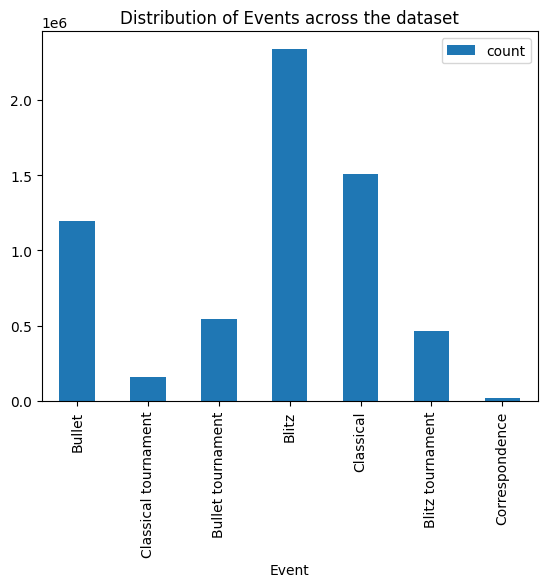

In [8]:
event_counts = df.groupBy('Event').agg(count('*').alias('count'))
event_counts_pd = event_counts.toPandas()

event_counts_pd.plot(kind='bar', x='Event', y='count')
plt.title('Distribution of Events across the dataset')
plt.show()

## Top 10 Chess Openings

The pie chart represents the distribution of the top 10 most popular chess openings in the dataset. Here's a brief explanation for few of them: 

1. Scandinavian Defense: The Scandinavian Defense is a chess opening characterized by the moves 1.e4 d5. It is known for its asymmetrical pawn structure and aims to establish a solid central presence for Black.

2. Van't Kruijs Opening: Van't Kruijs Opening, also known as the Dutch Attack, starts with the move 1.e3. It is a relatively uncommon opening that aims to control the center and develop the pieces harmoniously.

3. Modern Defense: The Modern Defense is a chess opening where Black plays 1.e4 g6, intending to build a flexible pawn structure and develop the pieces efficiently. It offers dynamic counterattacking possibilities.

4. Horwitz Defense: The Horwitz Defense is a chess opening that arises after the moves 1.e4 e5 2.Nf3 Nc6 3.Bc4 Be7. It is a solid and flexible defense aimed at developing the pieces and preparing for future pawn breaks.

The pie chart visualizes the relative popularity of these openings among the top 10. Each slice represents the percentage of games that started with a particular opening. The larger the slice, the more frequently the opening was played.

Understanding the distribution of popular openings can provide insights into the strategic preferences and trends in chess games. It can also serve as a reference for players looking to study and improve their opening repertoire.

### Creating a Pie Chart of Top 10 Openings Distribution using PySpark and Matplotlib

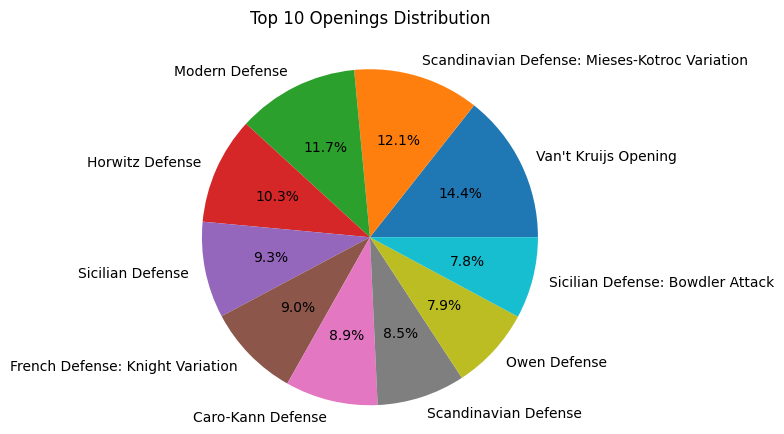

In [9]:
# Grouping games by opening and counting
opening_counts = df.groupBy("Opening").count().orderBy(desc("count")).limit(10)

# Converting DataFrame to Pandas for visualization
opening_counts_pd = opening_counts.toPandas()

# Plotting the pie chart
plt.pie(opening_counts_pd["count"], labels=opening_counts_pd["Opening"], autopct='%1.1f%%')
plt.title("Top 10 Openings Distribution\n")
plt.axis('equal')
plt.show()


## Finding the Maximum Rating of both White and Black players in the DataFrame

In [10]:
df.select(max(df.WhiteElo)).show()

+-------------+
|max(WhiteElo)|
+-------------+
|         3110|
+-------------+



In [11]:
df.select(max(df.BlackElo)).show()

+-------------+
|max(BlackElo)|
+-------------+
|         3108|
+-------------+



## Chess Game Terminations

The bar chart displays the frequency of different termination reasons in the dataset.

The bar chart illustrates the distribution of these termination reasons, providing insights into the different ways games concluded. Each bar represents the count or frequency of games that ended with a particular termination reason. The taller the bar, the more frequently that termination reason occurred.

Analyzing termination reasons can help identify common issues or situations that lead to game outcomes. It can also shed light on aspects like time management, adherence to rules, and tactical play in chess games.

### Creating a Bar Plot of Termination Counts using PySpark and Matplotlib

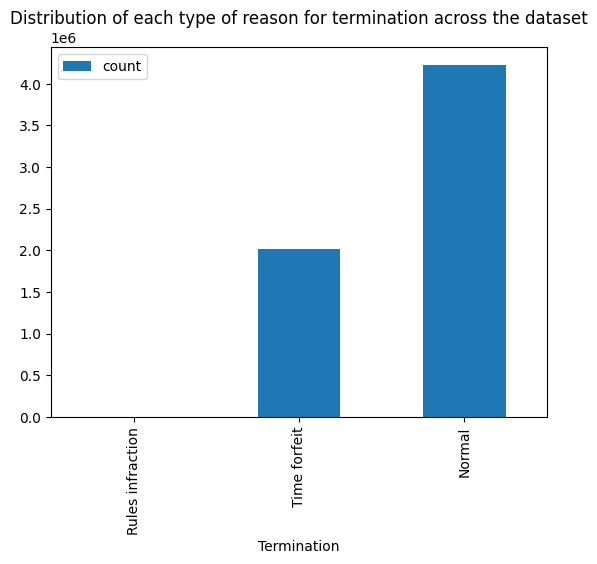

In [12]:
term_counts = df.groupBy('Termination').agg(count('*').alias('count'))
term_counts_pd = term_counts.toPandas()

term_counts_pd.plot(kind='bar', x='Termination', y='count')
plt.title('Distribution of each type of reason for termination across the dataset')
plt.show()

## Analyzing the Most Implemented Openings based on ECO Codes in a PySpark DataFrame


## Move Variation by Player Category

The horizontal bar chart represents the counts of unique moves by different player categories. Here's a breakdown of the data:

- Top rated whites: This category consists of highly rated white players. The count of unique moves for top rated whites is 492.

- Top rated blacks: This category includes highly rated black players. The count of unique moves for top rated blacks is also 492.

- Low rated whites: This category comprises whites with lower ratings. The count of unique moves for low rated whites is 434.

- Low rated blacks: This category consists of blacks with lower ratings. The count of unique moves for low rated blacks is also 434.

The chart provides insights into the variation of moves made by players across different rating categories. It allows for a comparison between highly rated and low-rated players in terms of the diversity of opening moves they employ.

In [13]:
top_rated_whites = df.filter(df.WhiteElo >= 1900)
top_rated_blacks = df.filter(df.BlackElo >= 1900)

low_rated_whites = df.filter(df.WhiteElo < 1500)
low_rated_blacks = df.filter(df.BlackElo < 1500)

avg_rated_whites = df.filter((df.WhiteElo >= 1500) & (df.WhiteElo < 1900))
avg_rated_blacks = df.filter((df.BlackElo >= 1500) & (df.BlackElo < 1900))

In [14]:
move_variation_data = [top_rated_whites.groupby('ECO').count().count(), top_rated_blacks.groupby('ECO').count().count(), low_rated_whites.groupby('ECO').count().count(), low_rated_blacks.groupby('ECO').count().count()]

### Move Variation by Player Category

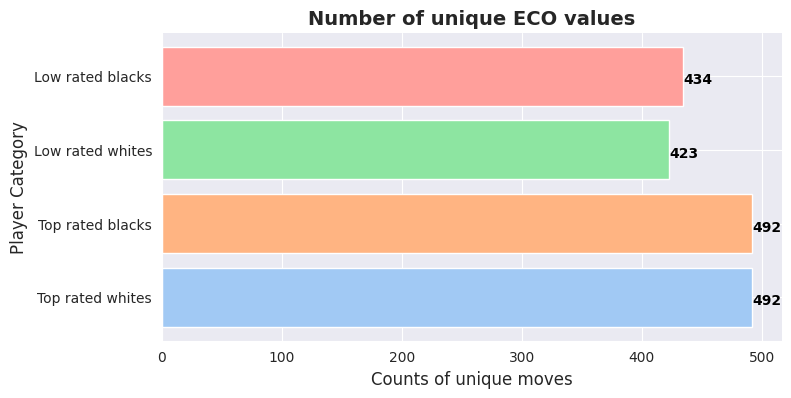

In [15]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(['Top rated whites', 'Top rated blacks', 'Low rated whites', 'Low rated blacks'], move_variation_data, color=sns.color_palette('pastel', 4))
ax.set_xlabel('Counts of unique moves', fontsize=12)
ax.set_ylabel('Player Category', fontsize=12)
ax.set_title('Number of unique ECO values', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10)
for i, v in enumerate(move_variation_data):
    ax.text(v + 0.25, i - 0.1, str(v), color='black', fontweight='bold', fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()

## Distribution of Player Elo Ratings


The histograms provide valuable information about the distribution and diversity of Elo ratings among players. They offer insights into the skill levels and rating patterns within the dataset, allowing for a deeper understanding of the player population.

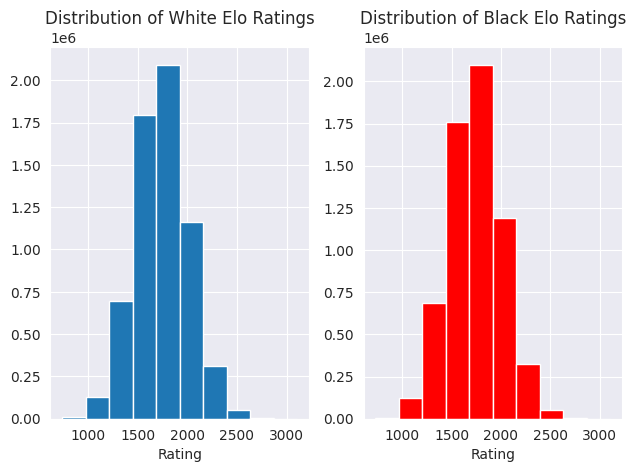

In [16]:
WhiteElo_df = df.select(df.WhiteElo)
white_elo_pd = WhiteElo_df.toPandas()

BlackElo_df = df.select(df.BlackElo)
black_elo_pd = BlackElo_df.toPandas()

fig, ax = plt.subplots(1,2)
x = white_elo_pd['WhiteElo']
ax[0].hist(x = x)
ax[0].set_title('Distribution of White Elo Ratings')
ax[0].set_xlabel('Rating')
y = black_elo_pd['BlackElo']
ax[1].hist(x = y,color = 'red')
ax[1].set_title('Distribution of Black Elo Ratings')
ax[1].set_xlabel('Rating')
fig.tight_layout(pad=1.0)
plt.show()

In [17]:
top_rated_whites_df = top_rated_whites.groupby(['Result']).count().sort(['count'],ascending = False).toPandas()
top_rated_blacks_df = top_rated_blacks.groupby(['Result']).count().sort(['count'],ascending = False).toPandas()
low_rated_whites_df = low_rated_whites.groupby(['Result']).count().sort(['count'],ascending = False).toPandas()
low_rated_blacks_df = low_rated_blacks.groupby(['Result']).count().sort(['count'],ascending = False).toPandas()
avg_rated_whites_df = avg_rated_whites.groupby(['Result']).count().sort(['count'],ascending = False).toPandas()
avg_rated_blacks_df = avg_rated_blacks.groupby(['Result']).count().sort(['count'],ascending = False).toPandas()

Text(0.5, 1.0, 'Victory distribution based on rating')

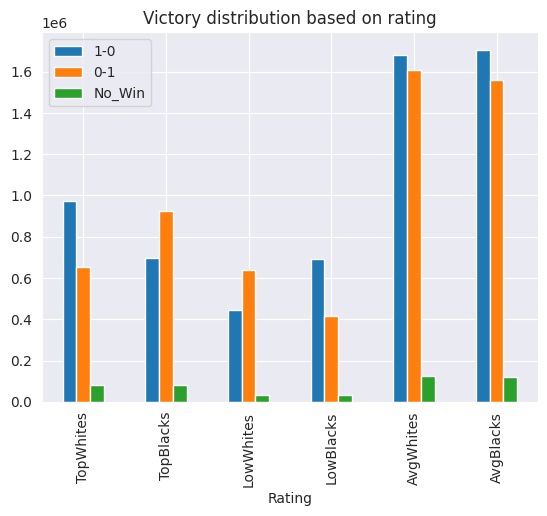

In [18]:
result_by_rating_df =  pd.DataFrame()
result_by_rating_df['Rating'] = ['TopWhites','TopBlacks','LowWhites','LowBlacks','AvgWhites','AvgBlacks']
result_by_rating_df['1-0'] = [top_rated_whites_df[top_rated_whites_df['Result'] == '1-0']['count'][0], top_rated_blacks_df[top_rated_blacks_df['Result'] == '1-0']['count'][1], low_rated_whites_df[low_rated_whites_df['Result'] == '1-0']['count'][1], low_rated_blacks_df[low_rated_blacks_df['Result'] == '1-0']['count'][0], avg_rated_whites_df[avg_rated_whites_df['Result'] == '1-0']['count'][0], avg_rated_blacks_df[avg_rated_blacks_df['Result'] == '1-0']['count'][0]]
result_by_rating_df['0-1'] = [top_rated_whites_df[top_rated_whites_df['Result'] == '0-1']['count'][1], top_rated_blacks_df[top_rated_blacks_df['Result'] == '0-1']['count'][0], low_rated_whites_df[low_rated_whites_df['Result'] == '0-1']['count'][0], low_rated_blacks_df[low_rated_blacks_df['Result'] == '0-1']['count'][1], avg_rated_whites_df[avg_rated_whites_df['Result'] == '0-1']['count'][1], avg_rated_blacks_df[avg_rated_blacks_df['Result'] == '0-1']['count'][1]]
result_by_rating_df['No_Win'] = [top_rated_whites_df[top_rated_whites_df['Result'] == '1/2-1/2']['count'][2], top_rated_blacks_df[top_rated_blacks_df['Result'] == '1/2-1/2']['count'][2], low_rated_whites_df[low_rated_whites_df['Result'] == '1/2-1/2']['count'][2], low_rated_blacks_df[low_rated_blacks_df['Result'] == '1/2-1/2']['count'][2], avg_rated_whites_df[avg_rated_whites_df['Result'] == '1/2-1/2']['count'][2], avg_rated_blacks_df[avg_rated_blacks_df['Result'] == '1/2-1/2']['count'][2]]
result_by_rating_df.plot(kind = 'bar', x = 'Rating' )
plt.title('Victory distribution based on rating')

## Can one increase the rating by playing a particular kind of event/tournament?

**Turns out the top rated players actually played 'Bullet' tournament significantly more number of times compared to average and low rated players. So, playing 'Bullet' tounament many times did impact their ratings!!**


In [19]:
top_rated = df.filter((df.WhiteElo >= 1900) | (df.BlackElo >= 1900))
low_rated = df.filter((df.WhiteElo < 1500) | (df.BlackElo < 1500))
avg_rated = df.filter(((df.WhiteElo < 1900) & (df.WhiteElo >= 1500))|((df.BlackElo < 1900) & (df.BlackElo >= 1500)))

In [20]:
event_top = top_rated.groupBy('Event').count().sort('count', ascending = False).toPandas()
event_low = low_rated.groupBy('Event').count().sort('count', ascending = False).toPandas()
event_avg = avg_rated.groupBy('Event').count().sort('count', ascending = False).toPandas()

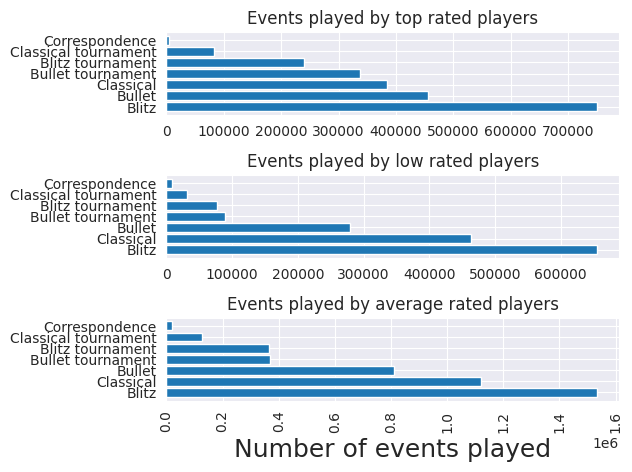

In [21]:
fig, ax = plt.subplots(3,1)
x = event_top['Event']
height = event_top['count']
ax[0].barh(y = x, width = height)
ax[0].set_title('Events played by top rated players')
x = event_low['Event']
height = event_low['count']
ax[1].barh(y = x, width = height)
ax[1].set_title('Events played by low rated players')
x = event_avg['Event']
height = event_avg['count']
ax[2].barh(y = x, width = height)
ax[2].set_title('Events played by average rated players')
plt.xticks(rotation = 90)
plt.xlabel(xlabel='Number of events played', fontsize=18)
fig.tight_layout(pad=1.0)
plt.show()

## Analyzing the Moves('AN') Column

Column 'AN' has a lot of potential in predicting the outcome of the game. For this particular analysis, we consider number of moves, number of white checks, number of black checks and if queenside or kingside castling were done on either side

In [22]:
df  = df.withColumn("Moves", regexp_replace(col("AN"), "\\d+\\.", ""))
df = df.withColumn("Moves", split(col("Moves"), "  "))
df = df.withColumn("ChecksArray", transform(col("Moves"), lambda x: length(regexp_replace(x, "[^+]", ""))))
df = df.withColumn("NumOfChecks", aggregate("ChecksArray", lit(0), lambda acc, x: acc + x))
df = df.withColumn("NumOfMoves", size(col("ChecksArray")))
df = df.withColumn("MoveArray", transform(col("Moves"), lambda x:split(x, ",") ))

In [23]:
df1 = df.withColumn("CheckMateArray", transform(col("Moves"), lambda x: length(regexp_replace(x, "[^#]", ""))))
df1 = df1.withColumn("NumOfCheckMates", aggregate("CheckMateArray", lit(0), lambda acc, x: acc + x))
df2 = df1.filter(df1.NumOfCheckMates!=0)
eff_op = df2.filter(df2.NumOfMoves<=10)
op_arr = eff_op.groupby('Opening').count().sort('count',ascending = False).select('Opening')
eff_op_pd = eff_op.toPandas()
op_arr_pd = op_arr.toPandas()
df = df.drop('CheckMateArray')

In [24]:
white_op = []
black_op = []
for opening in op_arr_pd.values:
    res_pd = eff_op_pd[eff_op_pd.Opening == opening[0]]['Result'].value_counts()
    if res_pd[res_pd.values == res_pd.values.max()].index[0] == '1-0':
        white_op.append(opening[0])
    else:
        black_op.append(opening[0])

In [25]:
mean_arr_w = []
mean_arr_b = []
for aop in white_op[:10]:
    mean_arr_w.append(eff_op_pd[eff_op_pd.Opening == aop]['NumOfMoves'].mean())
for bop in black_op[:10]:
    mean_arr_b.append(eff_op_pd[eff_op_pd.Opening == bop]['NumOfMoves'].mean())

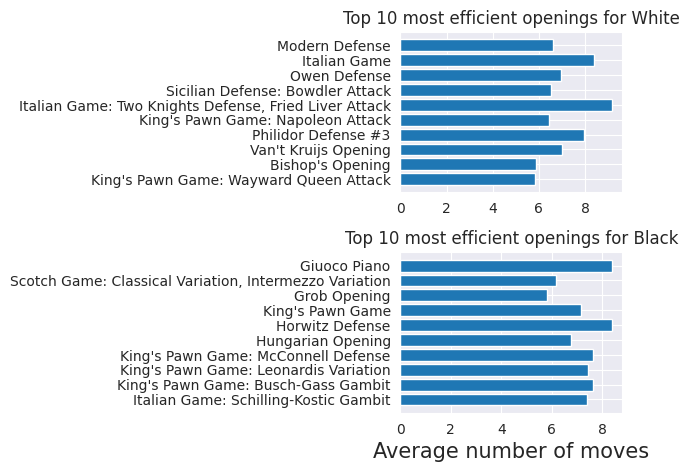

In [26]:
fig, ax = plt.subplots(2,1)
ax[0].barh(y = white_op[:10], width = mean_arr_w)
ax[0].set_title('Top 10 most efficient openings for White')
ax[1].barh(y = black_op[:10], width = mean_arr_b)
ax[1].set_title('Top 10 most efficient openings for Black')
plt.xlabel(xlabel='Average number of moves', fontsize=15)
fig.tight_layout(pad=1.0)
plt.show()